In [21]:

#  Compatibility imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np
import glob

from six.moves import xrange as range

import soundfile as sf
import matplotlib.pyplot as plt

In [6]:
try:
    from python_speech_features import mfcc
except ImportError:
    print("Failed to import python_speech_features.\n Try pip install python_speech_features.")
    raise ImportError

from utils import maybe_download as maybe_download
from utils import sparse_tuple_from as sparse_tuple_from

from keras.preprocessing.sequence import pad_sequences

In [4]:
import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk import ngrams

ModuleNotFoundError: No module named 'nltk'

In [2]:
nltk.download('punkt')

Using TensorFlow backend.


In [7]:
# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

# Some configs
num_features = 13
num_units=50 # Number of units in the LSTM cell
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 200
num_hidden = 50
num_layers = 2
batch_size = 1
initial_learning_rate = 1e-2
momentum = 0.9

num_examples = 1
num_batches_per_epoch = int(num_examples/batch_size)

In [8]:
ROOT_DIRECTORY = 'TIMIT_full/'

WAV_CLASS = '*.wav'
TXT_CLASS = '*.txt'

In [ ]:
Clean

In [14]:
TRAIN_DIRECTORY = 'train_16k/'
VAL_DIRECTORY = 'val_16k/'
TEST_DIRECTORY = 'test_16k/'

In [ ]:
Noisy

In [10]:
TRAIN_DIRECTORY = 'timit_train_16k/'
VAL_DIRECTORY = 'timit_val_16k/'
TEST_DIRECTORY = 'timit_test_16k/'

In [11]:
def load_dataset(wav_path,txt_path):

    x_s = []
    y_s = []
    text_s = []
    print(wav_path, txt_path)
    for e, (f1, f2) in enumerate( zip(sorted(glob.glob(wav_path)),sorted(glob.glob(txt_path))) ) :
#         print('FileName:',f1, f2)
        
        ##### Read Audio features #####
        ###############################
        audio, fs = sf.read(f1)
        inputs = mfcc(audio, samplerate=fs)
        
        # Tranform in 3D array
        train_inputs = np.asarray(inputs[np.newaxis, :])
        train_inputs = (train_inputs - np.mean(train_inputs))/np.std(train_inputs)
#         print('train_inputs.shape:', train_inputs.shape)
        
        train_seq_len = [train_inputs.shape[1]]
#         print('train_seq_len.len:', len(train_seq_len) )
        
        x_s.append(train_inputs)
#         print('x_s.len', len(x_s))
        
        ##### Read Labels features #####
        ###############################
        with open(f2, 'r') as txt_f:
            line = txt_f.readlines()[-1] #Only the last line is necessary

            targets = preprocess_line(line)
            text_s.append(targets)

            # Adding blank label
            targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

            # Transform char into index
            targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                                  for x in targets])

            # Creating sparse representation to feed the placeholder
            train_targets = sparse_tuple_from([targets])
#             print('train_targets.shape:', len(train_targets))
            y_s.append(train_targets)
              
    
    print('x_s.len', len(x_s),', [-1]x_s.len', x_s[-1].shape)
#     x_s = pad_sequences(x_s, maxlen=500, dtype='float', padding='post', truncating='post')
#     print('x_s.shape', (x_s.shape))
        
    
    return x_s, y_s,text_s
        

In [12]:
def preprocess_line(line):
    
    original = ' '.join(line.strip().lower().split(' ')[2:])
    for c in set(original):
        if c != ' ' and not c.isalpha():
            original = original.replace(c,'')
        
    targets = original.replace(' ', '  ')
    targets = targets.split(' ')

    i = 0
    while i<len(targets)-1:
        if targets[i]==targets[i+1] and targets[i+1]=='':
            del targets[i+1]
        else:
            i +=1
            
    return targets
    
    # Get only the words between [a-z] and replace period for none
#     original = ' '.join(line.strip().lower().split(' ')[2:]).replace('.', '').replace('\'','')
#     targets = original.replace(' ', '  ')
#     return targets.split(' ')

In [15]:
x_, y_,text_ = load_dataset(ROOT_DIRECTORY+TRAIN_DIRECTORY+WAV_CLASS, ROOT_DIRECTORY+TRAIN_DIRECTORY+TXT_CLASS)  
print(len(x_), len(y_))

TIMIT_full/train_16k/*.wav TIMIT_full/train_16k/*.txt
x_s.len 4576 , [-1]x_s.len (1, 204, 13)
4576 4576


In [16]:
val_x_, val_y_, val_text_ = load_dataset(ROOT_DIRECTORY+VAL_DIRECTORY+WAV_CLASS, ROOT_DIRECTORY+VAL_DIRECTORY+TXT_CLASS)  
print(len(val_x_), len(val_y_))

TIMIT_full/val_16k/*.wav TIMIT_full/val_16k/*.txt
x_s.len 44 , [-1]x_s.len (1, 194, 13)
44 44


In [17]:
test_x_, test_y_, test_text_ = load_dataset(ROOT_DIRECTORY+TEST_DIRECTORY+WAV_CLASS, ROOT_DIRECTORY+TEST_DIRECTORY+TXT_CLASS)  
print(len(test_x_), len(test_y_))

TIMIT_full/test_16k/*.wav TIMIT_full/test_16k/*.txt
x_s.len 1680 , [-1]x_s.len (1, 315, 13)
1680 1680


In [18]:
# THE MAIN CODE! LSTM

graph = tf.Graph()
with graph.as_default():
    # e.g: log filter bank or MFCC features
    # Has size [batch_size, max_stepsize, num_features], but the
    # batch_size and max_stepsize can vary along each step
    inputs = tf.placeholder(tf.float32, [None, None, num_features])

    # Here we use sparse_placeholder that will generate a
    # SparseTensor required by ctc_loss op.
    targets = tf.sparse_placeholder(tf.int32)

    # 1d array of size [batch_size]
    seq_len = tf.placeholder(tf.int32, [None])

    # Defining the cell
    # Can be:
    #   tf.nn.rnn_cell.RNNCell
    #   tf.nn.rnn_cell.GRUCell 
    cells = []
    for _ in range(num_layers):
        cell = tf.contrib.rnn.LSTMCell(num_units)  # Or LSTMCell(num_units)
        cells.append(cell)
    stack = tf.contrib.rnn.MultiRNNCell(cells)

    # The second output is the last state and we will no use that
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)

    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]

    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(outputs, [-1, num_hidden])

    # Truncated normal with mean 0 and stdev=0.1
    # Tip: Try another initialization
    # see https://www.tensorflow.org/versions/r0.9/api_docs/python/contrib.layers.html#initializers
    W = tf.Variable(tf.truncated_normal([num_hidden,
                                         num_classes],
                                        stddev=0.1))
    # Zero initialization
    # Tip: Is tf.zeros_initializer the same?
    b = tf.Variable(tf.constant(0., shape=[num_classes]))

    # Doing the affine projection
    logits = tf.matmul(outputs, W) + b

    # Reshaping back to the original shape
    logits = tf.reshape(logits, [batch_s, -1, num_classes])

    # Time major
    logits = tf.transpose(logits, (1, 0, 2))

    loss = tf.nn.ctc_loss(targets, logits, seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.MomentumOptimizer(initial_learning_rate,
                                           0.9).minimize(cost)

    # Option 2: tf.nn.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)

    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))

In [15]:
# THE MAIN CODE! BiLSTM+GRU

graph = tf.Graph()
with graph.as_default():
    # e.g: log filter bank or MFCC features
    # Has size [batch_size, max_stepsize, num_features], but the
    # batch_size and max_stepsize can vary along each step
    inputs = tf.placeholder(tf.float32, [None, None, num_features])

    # Here we use sparse_placeholder that will generate a
    # SparseTensor required by ctc_loss op.
    targets = tf.sparse_placeholder(tf.int32)

    # 1d array of size [batch_size]
    seq_len = tf.placeholder(tf.int32, [None])

    # Defining the cell
    # Can be:
    #   tf.nn.rnn_cell.RNNCell
    #   tf.nn.rnn_cell.GRUCell 
    cells = []
    for _ in range(num_layers):
        cell = tf.contrib.rnn.GRUCell(num_units)  # Or LSTMCell(num_units)
        cells.append(cell)
    stack = tf.contrib.rnn.MultiRNNCell(cells)
    
    cells_bw = []
    for _ in range(num_layers):
        cell_bw = tf.contrib.rnn.GRUCell(num_units)  # Or LSTMCell(num_units)
        cells_bw.append(cell_bw)
    stack_bw = tf.contrib.rnn.MultiRNNCell(cells)

    # The second output is the last state and we will no use that
    outputs, _ = tf.nn.bidirectional_dynamic_rnn(stack,stack_bw, inputs, seq_len, dtype=tf.float32)

    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]

    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(outputs, [-1, num_hidden])

    # Truncated normal with mean 0 and stdev=0.1
    # Tip: Try another initialization
    # see https://www.tensorflow.org/versions/r0.9/api_docs/python/contrib.layers.html#initializers
    W = tf.Variable(tf.truncated_normal([num_hidden,
                                         num_classes],
                                        stddev=0.1))
    # Zero initialization
    # Tip: Is tf.zeros_initializer the same?
    b = tf.Variable(tf.constant(0., shape=[num_classes]))

    # Doing the affine projection
    logits = tf.matmul(outputs, W) + b

    # Reshaping back to the original shape
    logits = tf.reshape(logits, [batch_s, -1, num_classes])

    # Time major
    logits = tf.transpose(logits, (1, 0, 2))

    loss = tf.nn.ctc_loss(targets, logits, seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.MomentumOptimizer(initial_learning_rate,
                                           0.9).minimize(cost)

    # Option 2: tf.nn.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)

    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))

batch: 0 4246 (1, 405, 13)
200 1976.6066131591797 4.0 2.321467638015747
Epoch 1/200, train_cost = 1976.607, train_ler = 4.000, val_cost = 176.181, val_ler = 2.000, time = 2.533
batch: 0 3893 (1, 389, 13)
200 2697.872573852539 3.850834310054779 2.7401297092437744
Epoch 2/200, train_cost = 2697.873, train_ler = 3.851, val_cost = 1231.738, val_ler = 1.874, time = 3.066
batch: 0 3300 (1, 247, 13)
200 1412.4134826660156 3.7042123675346375 2.5466465950012207
Epoch 3/200, train_cost = 1412.413, train_ler = 3.704, val_cost = 517.885, val_ler = 1.745, time = 2.776
batch: 0 3214 (1, 208, 13)
200 823.6518859863281 3.4106186628341675 2.0286641120910645
Epoch 4/200, train_cost = 823.652, train_ler = 3.411, val_cost = 660.005, val_ler = 1.746, time = 2.450
batch: 0 635 (1, 303, 13)
200 1087.6393280029297 3.5416603088378906 2.3202409744262695
Epoch 5/200, train_cost = 1087.639, train_ler = 3.542, val_cost = 262.486, val_ler = 1.660, time = 2.536
batch: 0 3850 (1, 300, 13)
200 971.4058685302734 3.3425

200 1080.8341064453125 4.474288463592529 1.8302841186523438
Epoch 44/200, train_cost = 1080.834, train_ler = 4.474, val_cost = 584.812, val_ler = 1.562, time = 2.157
batch: 0 748 (1, 291, 13)
200 911.7025146484375 3.134920656681061 2.2950332164764404
Epoch 45/200, train_cost = 911.703, train_ler = 3.135, val_cost = 646.696, val_ler = 1.619, time = 2.694
batch: 0 4065 (1, 331, 13)
200 975.6529998779297 3.1426987051963806 2.74700665473938
Epoch 46/200, train_cost = 975.653, train_ler = 3.143, val_cost = 598.065, val_ler = 1.480, time = 3.145
batch: 0 876 (1, 220, 13)
200 1138.7510833740234 3.1685675978660583 2.552401065826416
Epoch 47/200, train_cost = 1138.751, train_ler = 3.169, val_cost = 744.466, val_ler = 1.966, time = 2.881
batch: 0 3201 (1, 302, 13)
200 1118.7721405029297 3.3717570900917053 2.611130952835083
Epoch 48/200, train_cost = 1118.772, train_ler = 3.372, val_cost = 678.736, val_ler = 1.674, time = 2.936
batch: 0 2718 (1, 371, 13)
200 1122.4728698730469 3.5191876888275146 

200 729.6758346557617 3.4853479266166687 2.0011067390441895
Epoch 87/200, train_cost = 729.676, train_ler = 3.485, val_cost = 471.011, val_ler = 1.735, time = 2.329
batch: 0 1742 (1, 201, 13)
200 645.1705474853516 3.4273809790611267 2.099644899368286
Epoch 88/200, train_cost = 645.171, train_ler = 3.427, val_cost = 437.524, val_ler = 1.570, time = 2.371
batch: 0 1463 (1, 304, 13)
200 743.280517578125 3.3539811968803406 2.20461106300354
Epoch 89/200, train_cost = 743.281, train_ler = 3.354, val_cost = 443.201, val_ler = 1.764, time = 2.450
batch: 0 3930 (1, 297, 13)
200 935.5697784423828 3.225474774837494 2.2508630752563477
Epoch 90/200, train_cost = 935.570, train_ler = 3.225, val_cost = 544.854, val_ler = 1.591, time = 2.593
batch: 0 695 (1, 247, 13)
200 930.0602416992188 3.0405179262161255 2.393343687057495
Epoch 91/200, train_cost = 930.060, train_ler = 3.041, val_cost = 540.643, val_ler = 1.727, time = 2.830
batch: 0 3921 (1, 298, 13)
200 966.4389953613281 3.290788769721985 2.88190

200 801.8080291748047 3.2008960247039795 2.525789260864258
Epoch 130/200, train_cost = 801.808, train_ler = 3.201, val_cost = 316.187, val_ler = 1.591, time = 2.764
batch: 0 2532 (1, 459, 13)
200 922.5453186035156 3.5179367065429688 2.6285247802734375
Epoch 131/200, train_cost = 922.545, train_ler = 3.518, val_cost = 363.887, val_ler = 1.920, time = 2.896
batch: 0 1950 (1, 231, 13)
200 588.6575012207031 3.4102272391319275 2.096043109893799
Epoch 132/200, train_cost = 588.658, train_ler = 3.410, val_cost = 468.216, val_ler = 1.864, time = 2.349
batch: 0 574 (1, 243, 13)
200 685.1742706298828 3.607030928134918 2.2034292221069336
Epoch 133/200, train_cost = 685.174, train_ler = 3.607, val_cost = 273.556, val_ler = 1.714, time = 2.448
batch: 0 1372 (1, 302, 13)
200 966.7866821289062 3.5479076504707336 2.806178092956543
Epoch 134/200, train_cost = 966.787, train_ler = 3.548, val_cost = 513.828, val_ler = 1.811, time = 3.143
batch: 0 1214 (1, 409, 13)
200 857.2324829101562 3.1952959299087524

200 1010.2695617675781 3.1062905192375183 2.722501039505005
Epoch 173/200, train_cost = 1010.270, train_ler = 3.106, val_cost = 543.491, val_ler = 1.885, time = 2.989
batch: 0 1483 (1, 352, 13)
200 636.3333740234375 3.287994861602783 1.8621227741241455
Epoch 174/200, train_cost = 636.333, train_ler = 3.288, val_cost = 401.065, val_ler = 1.712, time = 2.142
batch: 0 599 (1, 223, 13)
200 838.6638946533203 3.356306731700897 2.0338690280914307
Epoch 175/200, train_cost = 838.664, train_ler = 3.356, val_cost = 631.428, val_ler = 1.596, time = 2.370
batch: 0 2616 (1, 389, 13)
200 921.0880279541016 3.156750500202179 2.421438217163086
Epoch 176/200, train_cost = 921.088, train_ler = 3.157, val_cost = 542.675, val_ler = 1.508, time = 2.802
batch: 0 2492 (1, 426, 13)
200 875.5821151733398 3.114104688167572 2.6204404830932617
Epoch 177/200, train_cost = 875.582, train_ler = 3.114, val_cost = 508.982, val_ler = 1.881, time = 2.884
batch: 0 2722 (1, 301, 13)
200 980.7071533203125 3.512890875339508 

<IPython.core.display.Javascript object>


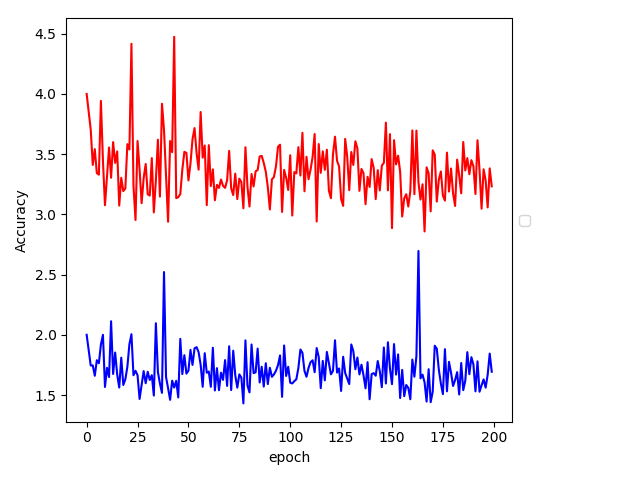

No handles with labels found to put in legend.


In [22]:
# Configuration to control GPU use
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33
# sess = tf.InteractiveSession(config=config)

num_batches_per_epoch = int(len(x_)/batch_size)

with tf.Session(graph=graph,config=config) as session:
    # Initializate the weights and biases
    tf.global_variables_initializer().run()
    
    train_epoch = range(num_epochs)
    train_edist = []
    val_edist = []

    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch//1000):
            b = int(np.random.randint(len(x_), size=1))
            if not batch%100:
                print('batch:', batch, b, x_[b].shape)
                
            feed = {inputs: x_[b],
                    targets: y_[b],
                    seq_len: [ x_[b].shape[1] ]}

            batch_cost, _ = session.run([cost, optimizer], feed)
            train_cost += batch_cost*batch_size
            train_ler += session.run(ler, feed_dict=feed)*batch_size

        train_cost /= num_examples
        train_ler /= num_examples
        
        print(num_epochs, train_cost, train_ler,time.time() - start)
        train_edist.append(train_ler)

        val_cost, val_ler = 0, 0
        for batch in range(len(val_x_)//20):
            b = int(np.random.randint(len(val_x_), size=1) )
            val_feed = {inputs: val_x_[b],
                        targets: val_y_[b],
                        seq_len: [val_x_[b].shape[1]]}

            val_c, val_l = session.run([cost, ler], feed_dict=val_feed)
            val_cost += val_c
            val_ler += val_l 

        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, val_cost = {:.3f}, val_ler = {:.3f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler,
                         val_cost, val_ler, time.time() - start))
        val_edist.append(val_ler)
    
    
    
    for batch in range(len(test_x_)//1000):
        b = int(batch)
        test_feed = {inputs: test_x_[b],
                        targets: test_y_[b],
                        seq_len: [test_x_[b].shape[1]]}
            
        # Decoding
        d = session.run(decoded[0], feed_dict=test_feed)
        str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])
        # Replacing blank label to none
        str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
        # Replacing space label to space
        str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

        print('Original:', test_text_[b])
        print('Decoded:' , str_decoded)
        
        %matplotlib notebook
        plt.figure()
        plt.plot(train_epoch, train_edist, 'r-')
        plt.plot(train_epoch, val_edist, 'b-')
        plt.xlabel("epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.subplots_adjust(right=0.8) 
        plt.show()